In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from mlxtend.plotting import plot_decision_regions

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '11869'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

## Logistic

0.5721726190476191

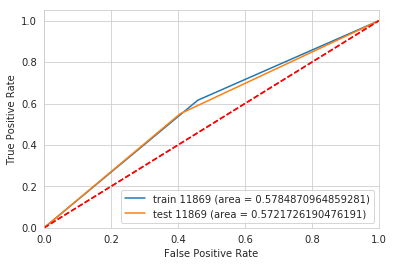

In [4]:
log_clf = lob.logistic_regression(df, 0, len(df))
pred_train = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
pred_test = log_clf.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
df['pred_log'] = pred_train
df_test['pred_log'] = pred_test
lob.plot_roc(df, log_clf, stock=int(stock), label='train')
lob.plot_roc(df_test, log_clf, stock=int(stock), label='test')

3054 6000


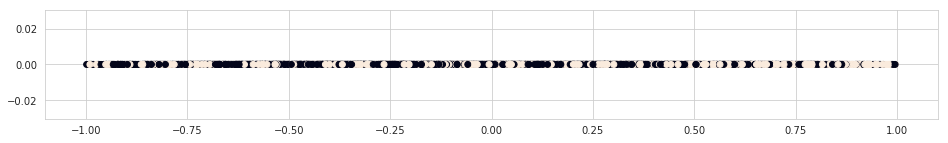

In [28]:
plt.figure(figsize=(16,2))
plt.scatter(df['queue_imbalance'], np.zeros(len(df)), c=df['mid_price_indicator'])
print(len(df[df['mid_price_indicator'] ==1]), len(df))

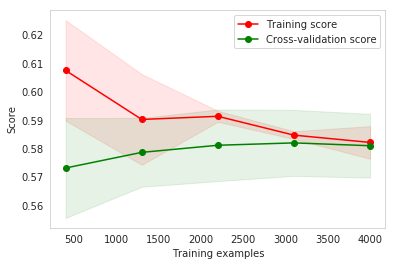

In [5]:
lob.plot_learning_curve(log_clf, df['queue_imbalance'].values.reshape(-1, 1), df['mid_price_indicator'])

### Let's look inside

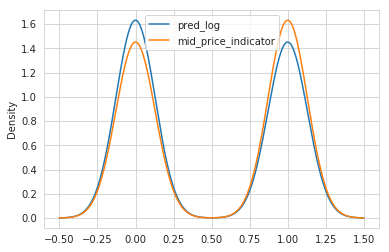

In [6]:
df_test[df_test['pred_log'] != df_test['mid_price_indicator']][['pred_log', 'mid_price_indicator']].plot(kind='kde')

In [7]:
print(len(df_test[df_test['pred_log'] != df_test['mid_price_indicator']]), len(df_test))
df_test[df_test['pred_log'] != df_test['mid_price_indicator']][['pred_log', 'mid_price_indicator', 'queue_imbalance']].head()

856 2000


,pred_log,mid_price_indicator,queue_imbalance
3,0.0,1.0,-0.201413
5,1.0,0.0,0.039879
10,1.0,0.0,0.681627
15,1.0,0.0,0.360843
16,1.0,0.0,0.664000


In [8]:
pivot = min(df[df['pred_log'] == 1]['queue_imbalance'])
pivot

-0.03934426229508197

In [9]:
print('Amount of positive samples below the pivot and negative above the pivot for training data:')
print(len(df[df['queue_imbalance'] < pivot][df['pred_log'] == 1]), 
      len(df[df['queue_imbalance'] >= pivot][df['pred_log'] == 0]))

print('Amount of positive samples below the pivot and negative above the pivot for testing data:')
print(len(df_test[df_test['queue_imbalance'] < pivot][df_test['pred_log'] == 1]), 
      len(df_test[df_test['queue_imbalance'] >= pivot][df_test['pred_log'] == 0]))

Amount of positive samples below the pivot and negative above the pivot for training data:
0 0
Amount of positive samples below the pivot and negative above the pivot for testing data:
0 0


So this classifier just finds a pivot. But why this particular one is choosen? Let's check what amount of data is below and above the pivot.

In [10]:
len(df[df['queue_imbalance'] < pivot]), len(df[df['queue_imbalance'] >= pivot])

(2765, 3235)

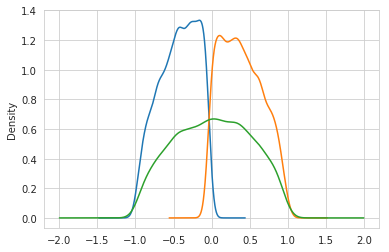

In [11]:
df[df['queue_imbalance'] < pivot]['queue_imbalance'].plot(kind='kde')
df[df['queue_imbalance'] >= pivot]['queue_imbalance'].plot(kind='kde')
df['queue_imbalance'].plot(kind='kde')

## SVM

In [12]:
overview_data = overview.Overview(stock, data_length)

gammas = [0.0005, 0.005, 1, 5, 50, 500, 5000]
cs = [0.0005, 0.005, 1, 5.0, 50, 500, 1000]
coef0s = [0, 0.0005, 0.005, 1, 5, 50, 500, 5000]

df_svm_res = overview_data.write_svm_results(df, df_cv, gammas=gammas, cs=cs, coef0s=coef0s)
unnamed_columns = [c for c in df_svm_res.columns if 'Unnamed' in c]
df_svm_res.drop(columns=unnamed_columns, inplace=True)
df_svm_res.sort_values(by='roc_cv_score').head()

Results read from file


,svm,c,gamma,coef0,roc_cv_score,roc_train_score
447,sigmoid,5.0,5000.0,0.0050,0.487149,0.462868
446,sigmoid,5.0,5000.0,0.0005,0.487149,0.463717
445,sigmoid,5.0,5000.0,0.0000,0.487631,0.463553
444,sigmoid,1.0,5000.0,1.0000,0.490782,0.459714
443,sigmoid,50.0,50.0,50.0000,0.495439,0.498900


In [13]:
df_svm_res[df_svm_res['svm'] == 'linear'].sort_values(by='roc_cv_score', ascending=False).head()

,svm,c,gamma,coef0,roc_cv_score,roc_train_score
39,linear,0.005,NaN,NaN,0.561807,0.578238
58,linear,1000.000,NaN,NaN,0.561696,0.577643
56,linear,50.000,NaN,NaN,0.561696,0.577807
54,linear,5.000,NaN,NaN,0.561696,0.577807
53,linear,500.000,NaN,NaN,0.561696,0.577807


In [14]:
df_svm_res.sort_values(by='roc_cv_score', ascending=False).head()

,svm,c,gamma,coef0,roc_cv_score,roc_train_score
0,sigmoid,0.005,500.000,5.0,0.565739,0.578554
1,rbf,0.005,50.000,NaN,0.565326,0.569674
2,sigmoid,0.005,5000.000,50.0,0.565183,0.580281
3,rbf,5.000,50.000,NaN,0.564847,0.581670
4,sigmoid,500.000,0.005,1.0,0.564812,0.578852


## Different kernels visualization

(0.006711409395973154, 0.005952380952380952, 0.5786666666666667)

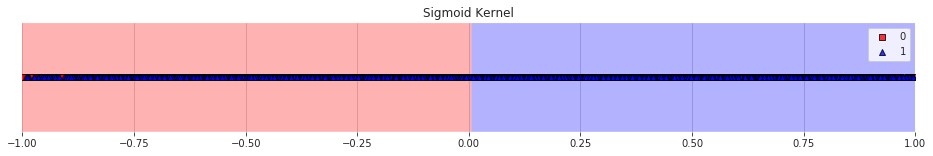

In [35]:
X = df[['queue_imbalance']].values
y = df['mid_price_indicator'].values.astype(np.integer)

clf = SVC(kernel='sigmoid', C=0.005, gamma=500, coef0=5.0)
clf.fit(df[['queue_imbalance']], df['mid_price_indicator'])

df['pred'] = clf.predict(df[['queue_imbalance']])
plt.figure(figsize=(16,2))
plot_decision_regions(X, y, clf=clf, legend='data')
plt.xlabel('')
plt.xlim(-1, 1)
plt.title('Sigmoid Kernel')
plt.legend()
min(df[df['pred'] == 1]['queue_imbalance']), max(df[df['pred'] == 0]['queue_imbalance']), clf.score(X, y)

(-0.997936016511868, -0.18875502008032127, 0.5723333333333334)

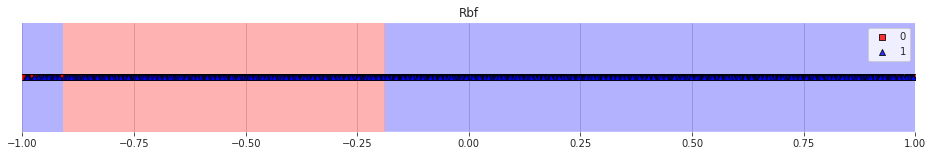

In [36]:
X = df[['queue_imbalance']].values
y = df['mid_price_indicator'].values.astype(np.integer)

clf = SVC(kernel='rbf', C=0.005, gamma=50)
clf.fit(df[['queue_imbalance']], df['mid_price_indicator'])
df['pred'] = clf.predict(df[['queue_imbalance']])
plt.figure(figsize=(16,2))
plot_decision_regions(X, y, clf=clf, legend='data')
plt.xlim(-1, 1)
plt.xlabel('')
plt.title('Rbf')
plt.legend()
min(df[df['pred'] == 1]['queue_imbalance']), max(df[df['pred'] == 0]['queue_imbalance']), clf.score(X, y)

(-0.032377428307123035, -0.032577903682719546, 0.5788333333333333)

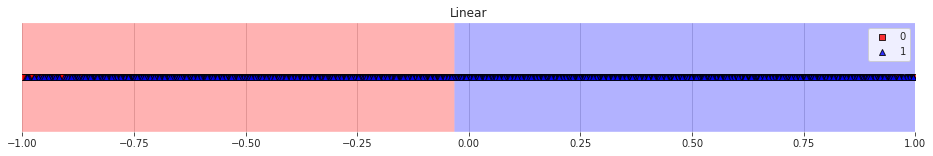

In [37]:
X = df[['queue_imbalance']].values
y = df['mid_price_indicator'].values.astype(np.integer)

clf = SVC(kernel='linear', C=0.005)
clf.fit(df[['queue_imbalance']], df['mid_price_indicator'])
df['pred'] = clf.predict(df[['queue_imbalance']])
plt.figure(figsize=(16,2))
plot_decision_regions(X, y, clf=clf, legend='data')
plt.xlabel('')
plt.xlim(-1, 1)
plt.title('Linear')
plt.legend()
min(df[df['pred'] == 1]['queue_imbalance']), max(df[df['pred'] == 0]['queue_imbalance']), clf.score(X, y)

In [ ]:
## Some plotly visualizations

In [ ]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

from plotly import tools
from itertools import product
py.init_notebook_mode(connected=True)

titles=['s']

clf1 = SVC(kernel='rbf')
clf1.fit(X, y)
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          subplot_titles=titles)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
y_ = np.arange(y_min, y_max, 0.1)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

trace1 = go.Contour(x=xx[0], y=y_, 
                    z=Z,
                    colorscale=[[0, 'purple'],
                                [0.5, 'cyan'],
                                [1, 'pink']],
                    opacity=0.5,
                    showscale=False)
trace2 = go.Scatter(x=X[:, 0], y=X[:, 1], 
                    showlegend=False,
                    mode='markers',
                    marker=dict(
                        color=y,
                        line=dict(color='black', width=1)))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
    
fig['layout'].update(hovermode='closest')

fig['layout'][x].update(showgrid=False, zeroline=False)
#fig['layout'][y].update(showgrid=False, zeroline=False)

py.iplot(fig)

In [ ]:
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

@interact(C=[1,2,3], gamma=[1,2,3], coef0=[1,2,3])
def _plot_lob(C, gamma, coef0):
    py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

    titles=['s']

    clf1 = SVC(kernel='rbf', C=C, gamma=gamma)
    clf1.fit(X, y)
    fig = tools.make_subplots(rows=1, cols=1,
                              print_grid=False,
                              subplot_titles=titles)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    y_ = np.arange(y_min, y_max, 0.1)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    trace1 = go.Contour(x=xx[0], y=y_, 
                        z=Z,
                        colorscale=[[0, 'purple'],
                                    [0.5, 'cyan'],
                                    [1, 'pink']],
                        opacity=0.5,
                        showscale=False)
    trace2 = go.Scatter(x=X[:, 0], y=X[:, 1], 
                        showlegend=False,
                        mode='markers',
                        marker=dict(
                            color=y,
                            line=dict(color='black', width=1)))

    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)

    fig['layout'].update(hovermode='closest')

    fig['layout'][x].update(showgrid=False, zeroline=False)
    #fig['layout'][y].update(showgrid=False, zeroline=False)

    py.iplot(fig)